<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Transfer_learning_using_pretrained_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If we want to build an image classifier, but we do not have enough training data, then it is often a good idea to take a pretrained network and reuse its lower layers, as we discussed in the notebook [Reusing pretrained layers](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Reusing_pretrained_layers_DNNs.ipynb).

A *pretrained* network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task. For instance, we might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the ImageNet dataset
(1.4 million labeled images and 1,000 different classes). ImageNet contains many animal and everyday objects classes, and we can thus expect to
perform well on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) classification problem.

We’ll use the VGG16 architecture (see notebook [CNN architectures](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/CNN_Architectures.ipynb)); it’s a simple and widely used convnet architecture for ImageNet. Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is is easy to understand. This may be our first encounter with one of these cutesy model names (VGG, ResNet, Inception, Inception-ResNet, Xception, and so on). 

There are two ways to use a pretrained network: *feature extraction* and *fine-tuning*.



## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.
Convnets used for image classification comprise two parts:
they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the *convolutional base* or the *feature extractor* of the model. In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output (see figure 5.14).

![](https://i.ibb.co/bWT7748/feature-xtraction.png)

Reuse the densely connected classifier should be avoided generally. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained (they will only contain information about the presence probability of this or that class in the entire picture). Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless.

The level of generality (and therefore reusability) of the representations
extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if our new dataset differs a lot from the dataset on which the original model was trained, we may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

Let’s put this in practice by using the convolutional base of the VGG16
network, trained on ImageNet, to extract interesting features from CIFAR-10
images, and then train a  classifier on top of these features.
The VGG16 model, among others, comes prepackaged with Keras. We can import
it from the `keras.applications module`. 

In [106]:
from tensorflow.keras import applications
IMG_SIZE = 32
# Load the VGG16 network, ensuring the head FC layer sets are left off
base_model = applications.VGG16(weights="imagenet", include_top=False,
                                input_shape=(IMG_SIZE, IMG_SIZE, 3))

We pass three arguments to the constructor:

- `weights` specifies the weight checkpoint from which to initialize the model.

- `include_top` refers to including (or not) the densely connected classifier on
top of the network. By default, this densely connected classifier corresponds to
the 1,000 classes from ImageNet. Because we intend to use our own densely
connected classifier (with only ten classes), we don’t need to include it.

- `input_shape` is the shape of the image tensors that we’ll feed to the network. This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is *fine-tuning*. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![texto alternativo](https://i.ibb.co/nCjDHHb/reuse-pretrained-layers.png)

For feature extraction, it’s necessary to freeze the convolution base in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follow:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.

Note that the first three steps are what we do for feature extraction. 


## Fine-tuning CIFAR-10 image classification

### Load packages

First let's import the needed packages and load the CIFAR-10 dataset. It's available in [tensorflow_datasets](https://www.tensorflow.org/datasets) (TFDS).

In [107]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import applications
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

### Load CIFAR-10 dataset

In [108]:
dataset_name = "cifar10"
(train, test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

By simply changing `dataset_name`, we may also try this notebook for other datasets in TFDS such as cifar100, stanford_dogs, food101, etc.

In [109]:
print('Number of classes: {}'.format(NUM_CLASSES))
print('Number of images in training data: {}'.format(
    tf.data.experimental.cardinality(train).numpy()))
print('Number of images in test data: {}'.format(
    tf.data.experimental.cardinality(test).numpy()))

Number of classes: 10
Number of images in training data: 50000
Number of images in test data: 10000


### Visualizing the data

The following code shows the first 9 images with their labels.

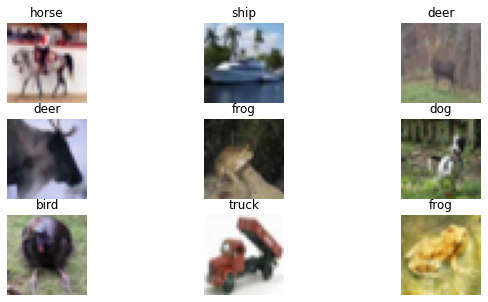

In [110]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

plt.figure(figsize=(10,5))
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Data augmentation

We can use [preprocessing layers](https://keras.io/guides/preprocessing_layers/) APIs for image augmentation.

In [111]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of the model we later build, and as a function to preprocess data before feeding into the model. Using them as function makes it easy to visualize the augmented images. Here we plot 9 examples of augmentation result of a given figure.

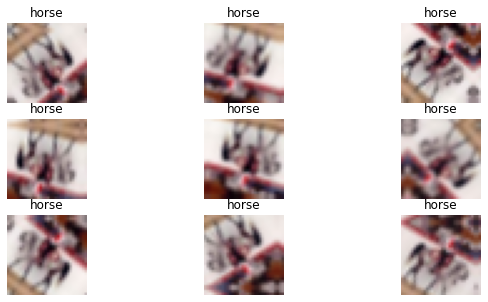

In [112]:
plt.figure(figsize=(10,5))
for image, label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

### Prepare inputs

Once we verify the input data and augmentation are working correctly, we prepare dataset for training. The labels are put into one-hot (categorical) encoding and the dataset is batched.

In [113]:
# One-hot  encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

BATCH_SIZE = 64 

ds_train = train.map(input_preprocess)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)


ds_test = test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [114]:
for batch_x, batch_y in ds_train.take(5):
    print(batch_x.shape)
    print(batch_y.shape)

(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)
(64, 32, 32, 3)
(64, 10)


### Transfer learning from pre-trained weights


Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on our own dataset. We create a VGG-16 model and download weights pretrained on the ImageNet dataset. We exclude the top of the network and add our own dense output layer with 10 units (1 unit per class), using the softmax activation function. Finally, we create the Keras Model :

In [115]:
IMG_SIZE = 32

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
# Load the VGG16 network, ensuring the head FC layer sets are left off
base_model = applications.VGG16(weights="imagenet", include_top=False,
                                input_tensor=x)

In [116]:
# Build the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(NUM_CLASSES, activation="softmax")(head_model)

# Place the head FC model on top of the base model
model = Model(inputs=inputs, outputs=head_model)

In [117]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
img_augmentation (Sequential (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147

Since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the weights of the pretrained layers, at least at the beginning of training (during the first few epochs) and train only the top layers, giving this layers some time to learn reasonable weights. To do this, we set every layer’s `trainable` attribute to `False` and compile the model:




In [118]:
for layer in base_model.layers:
	layer.trainable = False

A side note on freezing/unfreezing models: setting `trainable` of a Model will simultaneously set all layers belonging to the Model to the same trainable attribute. Each layer is trainable only if both the layer itself and the model containing it are trainable. Hence when we need to partially freeze/unfreeze a model, we need to make sure the `trainable` attribute of the model is set to `True`.

In [119]:
# Compile the model
opt = SGD(lr=1e-3, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
			  metrics=["accuracy"])

**Note**: We must always compile our model after we freeze or unfreeze layers.

Now we can train the model for a few epochs. Then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [120]:
# Train the model
hist = model.fit(
	x=ds_train, 
    batch_size=BATCH_SIZE,
	validation_data=ds_test,
	epochs=10)

Epoch 1/10
781/781 [==============================] - 14s 17ms/step - loss: 5.0182 - accuracy: 0.2621 - val_loss: 1.6950 - val_accuracy: 0.4176
Epoch 2/10
781/781 [==============================] - 11s 14ms/step - loss: 1.8833 - accuracy: 0.3357 - val_loss: 1.5941 - val_accuracy: 0.4467
Epoch 3/10
781/781 [==============================] - 11s 14ms/step - loss: 1.8167 - accuracy: 0.3612 - val_loss: 1.5498 - val_accuracy: 0.4625
Epoch 4/10
781/781 [==============================] - 11s 14ms/step - loss: 1.7650 - accuracy: 0.3738 - val_loss: 1.5448 - val_accuracy: 0.4658
Epoch 5/10
781/781 [==============================] - 11s 14ms/step - loss: 1.7511 - accuracy: 0.3792 - val_loss: 1.5377 - val_accuracy: 0.4626
Epoch 6/10
781/781 [==============================] - 11s 14ms/step - loss: 1.7233 - accuracy: 0.3890 - val_loss: 1.4809 - val_accuracy: 0.4827
Epoch 7/10
781/781 [==============================] - 11s 14ms/step - loss: 1.7015 - accuracy: 0.3960 - val_loss: 1.4796 - val_accuracy:

After training the model for a few epochs, the top layers are now pretty well trained, so we are ready to unfreeze all layers (or we could try unfreezing just the top ones), and continue training. This time we could use a lower learning rate to avoid damaging the pretrained weights:

In [121]:
for layer in base_model.layers:
	layer.trainable = True

In [122]:
opt = SGD(lr=1e-3, momentum=0.9) 
model.compile(loss="categorical_crossentropy", optimizer=opt,
			  metrics=["accuracy"])

In [123]:
hist = model.fit(
	x=ds_train, 
    batch_size=BATCH_SIZE,
	validation_data=ds_test,
	epochs=25)

Epoch 1/25
781/781 [==============================] - 31s 38ms/step - loss: 1.6384 - accuracy: 0.4105 - val_loss: 1.1290 - val_accuracy: 0.6145
Epoch 2/25
781/781 [==============================] - 30s 38ms/step - loss: 1.1549 - accuracy: 0.6028 - val_loss: 1.0450 - val_accuracy: 0.6423
Epoch 3/25
781/781 [==============================] - 30s 38ms/step - loss: 1.0169 - accuracy: 0.6497 - val_loss: 1.0577 - val_accuracy: 0.6632
Epoch 4/25
781/781 [==============================] - 30s 38ms/step - loss: 0.9383 - accuracy: 0.6809 - val_loss: 0.8884 - val_accuracy: 0.7065
Epoch 5/25
781/781 [==============================] - 30s 38ms/step - loss: 0.8694 - accuracy: 0.7024 - val_loss: 0.8558 - val_accuracy: 0.7121
Epoch 6/25
781/781 [==============================] - 30s 38ms/step - loss: 0.8291 - accuracy: 0.7181 - val_loss: 0.7900 - val_accuracy: 0.7383
Epoch 7/25
781/781 [==============================] - 30s 38ms/step - loss: 0.7819 - accuracy: 0.7311 - val_loss: 0.7410 - val_accuracy:

### Model evaluation

In [124]:
print(model.evaluate(ds_test))


156/156 [==============================] - 2s 10ms/step - loss: 0.5709 - accuracy: 0.8153
[0.5708931684494019, 0.8153044581413269]


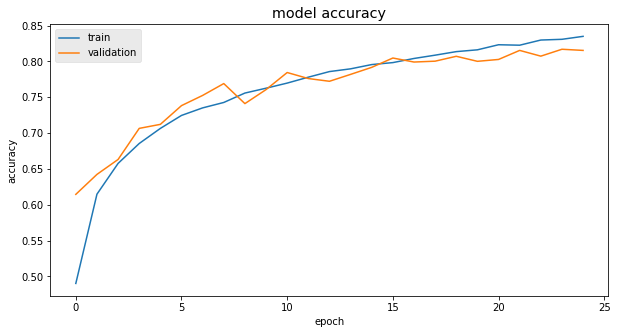

In [125]:
# Plotting the training and validation accuracy
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.style.use("ggplot")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plt.figure(figsize=(10,5))
plot_hist(hist)

### Predictions

In [126]:
predictions = model.predict(ds_test)

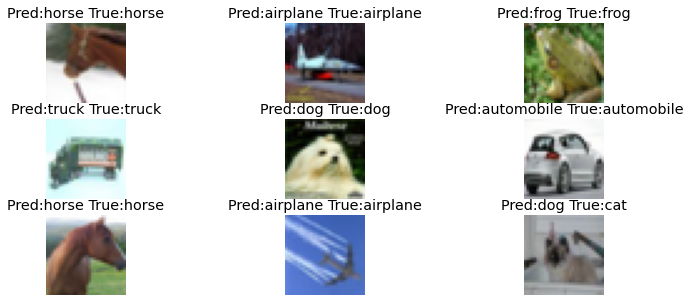

In [127]:
plt.figure(figsize=(10,5))
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(test.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.subplots_adjust(wspace = 2)
    label_prediction = predictions.argmax(axis=1)[i]
    plt.title("Pred:{} True:{}".format(
        format_label(label_prediction),
        format_label(label)))
    plt.axis("off")

# References

- Deep Learning wirh Python, François Chollet.

- [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

- [Transfer learning & fine-tuning with Keras](https://keras.io/guides/transfer_learning/)

- [Fine-tuning with Keras](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)

- [Working with preprocessing layers](https://keras.io/guides/preprocessing_layers/)

- [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

- [Transfer learning and fine-tuning wint TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning)

- [Transfer learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)